Extract data volume and revenue of each company

In [18]:
import pandas as pd
import re

# Load the CSV file
file_path = 'csv/bianlian_web_scraped.csv'
df = pd.read_csv(file_path)

# Define a function to extract the relevant fields from the "Content" column
def extract_info(content):
    # Split content by lines
    lines = content.split('\n')
    
    # Extracting the company name from the first line
    company_name = lines[0].strip() if len(lines) > 0 else None
    
    # Extracting the company website from the second line
    website = lines[1].strip() if len(lines) > 1 else None

    # Check if the website starts with "https", otherwise set to None
    if website and not website.startswith("http"):
        website = None

    # Extracting the description from the third line
    description = lines[2].strip() if len(lines) > 2 else None
    
    # Extracting the revenue from the line that contains 'Revenue:'
    revenue = None
    data_volume = None
    data_type = None
    industry = None
    for line in lines:
        if 'Revenue:' in line:
            revenue = line.split('Revenue:')[-1].strip()
            
        if "Data volume" in line:
            data_volume = line.split('Data volume:')[-1].strip()
            
        if "Data Volume" in line:
            data_volume = line.split('Data Volume:')[-1].strip()

    return pd.Series([company_name, website, description, industry, revenue, data_volume, data_type])

# Apply the extraction function to the "Content" column
extracted_df = df['Content'].apply(extract_info)
extracted_df.columns = ['Company Name', 'Company Website', 'Description', 'Industry', 'Revenue', 'Data Volume', 'Data Type']

# Add the original content column to the extracted dataframe
extracted_df['Original Content'] = df['Content']

# Display the cleaned dataframe
display(extracted_df)

# Save the cleaned dataframe to a new CSV if needed
extracted_df.to_csv('csv/bianlian_cleaning_part_one.csv', index=False)


,Company Name,Company Website,Description,Industry,Revenue,Data Volume,Data Type,Original Content
0,Benson Kearley IFG - Insurance Brokers & Finan...,http://bkifg.com,Benson Kearley IFG offers personal and commerc...,None,> $20 Millions,1.4 TB,None,Benson Kearley IFG - Insurance Brokers & Finan...
1,"Law Offices of Michael J Gurfinkel, Inc",https://gurfinkel.com,"The Law Offices of Michael J. Gurfinkel, Inc. ...",None,< $5 Millions,400 Gb,None,"Law Offices of Michael J Gurfinkel, Inc\nhttps..."
2,Stein Fibers,https://steinfibers.com,"Founded in 1976, Stein Fibers, Ltd. is a suppl...",None,None,None,None,Stein Fibers\nhttps://steinfibers.com\nFounded...
3,Majestic Metals,https://fathommfg.com/fathom-denver,Majestic Metals is a precision sheet metal fab...,None,$24.1 Millions,735 GB,None,Majestic Metals\nhttps://fathommfg.com/fathom-...
4,Ladov Law Firm,None,Revenue: <$5 Millions,None,<$5 Millions,105 GB,None,Ladov Law Firm\nLadov Law Firm PC is a company...
...,...,...,...,...,...,...,...,...
89,"Mayer Antonellis Jachowicz & Haranas, LLP",https://hkwg.com,"The Massachusetts law firm of Mayer & Haranas,...",None,> $5 Millions,170 Gb,None,"Mayer Antonellis Jachowicz & Haranas, LLP\nhtt..."
90,Shoma group,https://www.shomagroup.com/,Shoma Group is a real estate development compa...,None,> $20 Millions,2 Tb,None,Shoma group\nhttps://www.shomagroup.com/\nShom...
91,Lindsay Municipal Hospital,http://lindsayhospital.com,Lindsay Municipal Hospital proudly serves the ...,None,$13 Millions,None,None,Lindsay Municipal Hospital\nhttp://lindsayhosp...
92,"Palmer Construction Co., Inc",https://palmerconstruction.net,"Palmer Construction is a design-build, general...",None,> $13 Millions,475 Gb,None,"Palmer Construction Co., Inc\nhttps://palmerco..."


Extract data types of stolen data

In [13]:
import difflib
import pandas as pd

# Load the CSV file into a dataframe
file_path = 'csv/bianlian_cleaning_part_one.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Define separate keyword lists for each column
keywords_dict = {
    "Financial Data": ["finance", "financial", "budget", "accounting"],
    "PII": ["personal", "identifiable", "pii"],
    "Customer and Client Data": ["customer", "client", "consumer"],
    "Employee and HR data": ["employee", "hr", "human resources", "hr data"],
    "Legal Documents": ["legal", "court", "casefile", "litigation"],
    "Intellectual Property and Trade Secrets": ["intellectual property", "trade secret", "ip", "design"],
    "Databases": ["database", "databases", "db"],
    "Sensitive Communication": ["communication", "email", "chat", "message", "correspondence"],
    "Healthcare Data": ["health", "medical", "healthcare"],
    "Utility and Infrastructure Data": ["utility", "infrastructure", "power", "water"]
}

# Initialize the new columns in the dataframe with False values
for col in keywords_dict:
    df[col] = False
    
df['Data Type'] = df['Data Type'].str.replace('\n', ' ', regex=False)


# Function to find the closest match for each category
def match_keywords(data_type, keywords_dict):
    matches = {col: False for col in keywords_dict}
    for col, keywords in keywords_dict.items():
        for keyword in keywords:
            if difflib.get_close_matches(data_type, keywords, cutoff=0.7):
                matches[col] = True
    return matches

# Apply the matching logic to the dataframe
def update_sensitive_columns_difflib(row):
    data_type = str(row['Data Type']).lower() if pd.notna(row['Data Type']) else ""
    
    # Split the 'Data Type' column by whitespace (in case entries are separated by newline or spaces)
    data_entries = data_type.split(' ')
    
    # Initialize column match flags
    column_matches = {col: False for col in keywords_dict}
    
    # Check each entry in the data type
    for entry in data_entries:
        entry_matches = match_keywords(entry.strip(), keywords_dict)
        
        # Update match flags for each column
        for col, match in entry_matches.items():
            if match:
                column_matches[col] = True
    
    # Update the row with the match results
    for col, match in column_matches.items():
        row[col] = match
    
    return row

# Apply the function to each row of the dataframe
df = df.apply(update_sensitive_columns_difflib, axis=1)

# Move the 'Original Content' column to the last position
original_content = df.pop('Original Content')
df['Original Content'] = original_content

# Display the updated dataframe to the user
df.head()
df.to_csv('csv/bianlian_cleaning_part_two.csv', index=False)


In [5]:
import pandas as pd

# Load the CSV file
file_path = 'csv/bianlian_cleaned_final.csv'
df = pd.read_csv(file_path)

# List of column names to check
columns_to_check = [
    'PII', 'Customer and Client Data', 'Employee and HR data', 'Legal Documents',
    'Intellectual Property and Trade Secrets', 'Databases', 'Sensitive Communication',
    'Healthcare Data', 'Utility and Infrastructure Data'
]

# Create a new column 'RansomDataType' that will store the appended column names
df['RansomDataType'] = ''

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Initialize an empty list to store the names of columns with 'True' values
    ransom_data_types = []
    
    # Check each column in 'columns_to_check'
    for col in columns_to_check:
        if col in df.columns and row[col] == True:  # Adjust condition based on actual 'True' representation
            ransom_data_types.append(col)
    
    # Join the list into a comma-separated string and assign it to the 'RansomDataType' column
    df.at[index, 'RansomDataType'] = ', '.join(ransom_data_types)

# Display the updated dataframe
display(df[['RansomDataType']].head())
display(df)
# Optionally, save the updated dataframe to a new CSV file
# df.to_csv('/path/to/save/updated_file.csv', index=False)


,RansomDataType
0,"PII, Customer and Client Data, Employee and HR..."
1,"PII, Customer and Client Data, Sensitive Commu..."
2,
3,"Customer and Client Data, Employee and HR data..."
4,"PII, Customer and Client Data, Employee and HR..."


,CompanyName,Website,Description,Industry,Linkedin Industry,Revenue,RansomDataSize,Data Type,Country,Linkedin Country,...,Healthcare Data,Utility and Infrastructure Data,Original Content,HQ,Description (LinkedIn),CompanySize,DateVictimized,NumViews (of threat),RansomDataType,RansomwareGroup
0,Benson Kearley IFG - Insurance Brokers & Finan...,http://bkifg.com,Benson Kearley IFG offers personal and commerc...,NaN,Insurance,> $20 Millions,1.4 TB,"Customer data banks Medical, Business, Auto an...",NaN,Canada,...,True,False,Benson Kearley IFG - Insurance Brokers & Finan...,"Newmarket, ON",Benson Kearley IFG is an independent insurance...,51-200 employees,NaN,NaN,"PII, Customer and Client Data, Employee and HR...",BianLian
1,"Law Offices of Michael J Gurfinkel, Inc",https://gurfinkel.com,"The Law Offices of Michael J. Gurfinkel, Inc. ...",Legal,Legal Services,< $5 Millions,400 Gb,"Clients Personal Data. Accounting, budget, fin...",USA,USA,...,False,False,"Law Offices of Michael J Gurfinkel, Inc\nhttps...","GLENDALE, California","The Law Offices of Michael J. Gurfinkel, Inc. ...",11-50 employees,NaN,NaN,"PII, Customer and Client Data, Sensitive Commu...",BianLian
2,Stein Fibers,https://steinfibers.com,"Founded in 1976, Stein Fibers, Ltd. is a suppl...",NaN,Manufacturing,NaN,NaN,NaN,NaN,USA,...,False,False,Stein Fibers\nhttps://steinfibers.com\nFounded...,"Albany, New York","OUR MISSION\n\nStein Fibers, Ltd. has a straig...",201-500 employees,NaN,NaN,,BianLian
3,Majestic Metals,https://fathommfg.com/fathom-denver,Majestic Metals is a precision sheet metal fab...,Manufacturing,Manufacturing,$24.1 Millions,735 GB,Finance data HR data Partners and customers da...,USA,USA,...,False,False,Majestic Metals\nhttps://fathommfg.com/fathom-...,Colorado,We manufacture complete metal buildings and me...,51-200 employees,NaN,NaN,"Customer and Client Data, Employee and HR data...",BianLian
4,Ladov Law Firm,NaN,Ladov Law Firm PC is a company that operates i...,Legal,Legal Services,<$5 Millions,105 GB,HR data Casefiles Court and litigations data E...,USA,USA,...,False,False,Ladov Law Firm\nLadov Law Firm PC is a company...,"Philadelphia, Pennsylvania","Located in the heart of Philadelphia, Ladov La...",1-50 employees,NaN,NaN,"PII, Customer and Client Data, Employee and HR...",BianLian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"Mayer Antonellis Jachowicz & Haranas, LLP",https://hkwg.com,"The Massachusetts law firm of Mayer & Haranas,...",Legal,Legal Services,> $5 Millions,170 Gb,Legal paper work. Client data. Financial data....,NaN,USA,...,False,False,"Mayer Antonellis Jachowicz & Haranas, LLP\nhtt...","Framingham, Massachusetts",www.hkwg.com,11-50 employees,NaN,NaN,"Customer and Client Data, Legal Documents, Sen...",BianLian
90,Shoma group,https://www.shomagroup.com/,Shoma Group is a real estate development compa...,NaN,Real Estate,> $20 Millions,2 Tb,"Accidents. Accounting, budget, financial data....",NaN,USA,...,False,False,Shoma group\nhttps://www.shomagroup.com/\nShom...,"Coral Gables, Florida","30+ years of history, a strong track record an...",51-200 employees,NaN,NaN,"PII, Employee and HR data, Sensitive Communica...",BianLian
91,Lindsay Municipal Hospital,http://lindsayhospital.com,Lindsay Municipal Hospital proudly serves the ...,Healthcare,Healthcare,$13 Millions,NaN,NaN,USA,USA,...,False,False,Lindsay Municipal Hospital\nhttp://lindsayhosp...,"Lindsay, Oklahoma",Lindsay Municipal Hospital Home,51-200 employees,NaN,NaN,,BianLian
92,"Palmer Construction Co., Inc",https://palmerconstruction.net,"Palmer Construction is a design-build, general...",NaN,Construction,> $13 Millions,475 Gb,"Personal Data. Accounting, budget, financial d...",NaN,USA,...,False,False,"Palmer Construction Co., Inc\nhttps://palmerco...","McConnellsburg, Pennsylvania",As a Pennsylvania based commercial constructio...,11-50 employees,NaN,NaN,"PII, Employee and HR data",BianLian


In [6]:
# Define the desired column order
desired_columns = [
    "CompanyName", "Website", "Industry", "HQ", "Country", 
    "Description (LinkedIn)", "CompanySize", "DateVictimized", 
    "NumViews (of threat)", "RansomDataSize", "RansomDataType", 
    "RansomwareGroup"
]

# Get the remaining columns that are not in the desired order
remaining_columns = [col for col in df.columns if col not in desired_columns]

# Reorder the dataframe
df = df[desired_columns + remaining_columns]

In [11]:
display(df)
df.to_csv('csv/bianlian_cleaned_final2.csv', index=False)

,CompanyName,Website,Industry,HQ,Country,Description (LinkedIn),CompanySize,DateVictimized,NumViews (of threat),RansomDataSize,...,PII,Customer and Client Data,Employee and HR data,Legal Documents,Intellectual Property and Trade Secrets,Databases,Sensitive Communication,Healthcare Data,Utility and Infrastructure Data,Original Content
0,Benson Kearley IFG - Insurance Brokers & Finan...,http://bkifg.com,NaN,"Newmarket, ON",NaN,Benson Kearley IFG is an independent insurance...,51-200 employees,NaN,NaN,1.4 TB,...,True,True,True,False,False,False,False,True,False,Benson Kearley IFG - Insurance Brokers & Finan...
1,"Law Offices of Michael J Gurfinkel, Inc",https://gurfinkel.com,Legal,"GLENDALE, California",USA,"The Law Offices of Michael J. Gurfinkel, Inc. ...",11-50 employees,NaN,NaN,400 Gb,...,True,True,False,False,False,False,True,False,False,"Law Offices of Michael J Gurfinkel, Inc\nhttps..."
2,Stein Fibers,https://steinfibers.com,NaN,"Albany, New York",NaN,"OUR MISSION\n\nStein Fibers, Ltd. has a straig...",201-500 employees,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,Stein Fibers\nhttps://steinfibers.com\nFounded...
3,Majestic Metals,https://fathommfg.com/fathom-denver,Manufacturing,Colorado,USA,We manufacture complete metal buildings and me...,51-200 employees,NaN,NaN,735 GB,...,False,True,True,False,False,True,True,False,False,Majestic Metals\nhttps://fathommfg.com/fathom-...
4,Ladov Law Firm,NaN,Legal,"Philadelphia, Pennsylvania",USA,"Located in the heart of Philadelphia, Ladov La...",1-50 employees,NaN,NaN,105 GB,...,True,True,True,True,False,False,True,False,False,Ladov Law Firm\nLadov Law Firm PC is a company...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"Mayer Antonellis Jachowicz & Haranas, LLP",https://hkwg.com,Legal,"Framingham, Massachusetts",NaN,www.hkwg.com,11-50 employees,NaN,NaN,170 Gb,...,False,True,False,True,False,False,True,False,False,"Mayer Antonellis Jachowicz & Haranas, LLP\nhtt..."
90,Shoma group,https://www.shomagroup.com/,NaN,"Coral Gables, Florida",NaN,"30+ years of history, a strong track record an...",51-200 employees,NaN,NaN,2 Tb,...,True,False,True,False,False,False,True,False,False,Shoma group\nhttps://www.shomagroup.com/\nShom...
91,Lindsay Municipal Hospital,http://lindsayhospital.com,Healthcare,"Lindsay, Oklahoma",USA,Lindsay Municipal Hospital Home,51-200 employees,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,Lindsay Municipal Hospital\nhttp://lindsayhosp...
92,"Palmer Construction Co., Inc",https://palmerconstruction.net,NaN,"McConnellsburg, Pennsylvania",NaN,As a Pennsylvania based commercial constructio...,11-50 employees,NaN,NaN,475 Gb,...,True,False,True,False,False,False,False,False,False,"Palmer Construction Co., Inc\nhttps://palmerco..."


In [9]:
display(df['RansomDataType'])

0     PII, Customer and Client Data, Employee and HR...
1     PII, Customer and Client Data, Sensitive Commu...
2                                                      
3     Customer and Client Data, Employee and HR data...
4     PII, Customer and Client Data, Employee and HR...
                            ...                        
89    Customer and Client Data, Legal Documents, Sen...
90    PII, Employee and HR data, Sensitive Communica...
91                                                     
92                            PII, Employee and HR data
93                                                     
Name: RansomDataType, Length: 94, dtype: object

In [12]:
import pandas as pd

# Load the CSV file from the parent directory
file_path = 'csv/merged_bianlian_dates_remove_qilin_dates.csv'  # Adjust for the correct path
data = pd.read_csv(file_path)

# Function to reclassify industries
def reclassify_industry(industry):
    industry = industry.strip().lower()  # Clean and normalize industry names
    if industry in ['it services', 'it services a', 'it services ', 'information technology & services', 'it services and it consulting', 'it', 'software']:
        return 'Information Technology & Services'
    elif industry in ['manufacturing', 'industrial machinery manufacturing', 'textile manufacturing', 'motor vehicle manufacturing', 
                      'appliances, electrical, and electronics manufacturing']:
        return 'Manufacturing'
    elif industry in ['food production', 'food & beverages', 'food and beverage services', 'food and beverage manufacturing', 
                      'food\r\nbeverages\r\nmanufacturing']:
        return 'Food & Beverage'
    elif industry in ['environmental services', 'enviromental services', 'renewables & environment']:
        return 'Environmental Services'
    elif industry in ['retail', 'retail apparel and fashion', 'retail office equipment', 'retail luxury goods and jewelry']:
        return 'Retail'
    elif industry in ['design', 'design services']:
        return 'Design Services'
    elif industry in ['business services', 'business consulting and services']:
        return 'Business Services'
    elif industry in ['media', 'media and internet', 'media production', 'entertainment', 'entertainment providers']:
        return 'Media & Entertainment'
    elif industry in ['contrating', 'contruction', 'construction']:
        return 'Construction'
    elif industry in ['cosumer services', 'consumer services']:
        return 'Consumer Services'
    elif industry in ['legal', 'legal services']:
        return 'Legal Services'
    elif industry in ['finance', 'financial services']:
        return 'Financial Services'
    else:
        return industry.title()  # Capitalize the first letter of each word for standardization

# Apply the reclassification
data_clean['Reclassified Industry'] = data_clean['Industry'].apply(reclassify_industry)

# Count the unique reclassified industries
unique_reclassified_industries = data_clean['Reclassified Industry'].value_counts()

# Display the unique reclassified industries and their counts
print(unique_reclassified_industries)

# Save the cleaned and reclassified data to a new CSV file if needed
data_clean.to_csv('csv/reclassified_industries.csv', index=False)


Manufacturing                                          49
Construction                                           47
Unknown                                                32
Information Technology & Services                      25
Healthcare                                             24
Legal Services                                         16
Business Services                                      15
Financial Services                                     15
Retail                                                 13
Hospitality                                            12
Transportation                                         11
Real Estate                                            10
Utilities                                              10
Accounting                                              9
Food & Beverage                                         9
Telecommunications                                      8
Media & Entertainment                                   7
Insurance     

C:\Users\Banan\AppData\Local\Temp\ipykernel_21896\502958770.py:21: UserWarning: Glyph 13 (
) missing from current font.
  plt.tight_layout()
C:\Users\Banan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


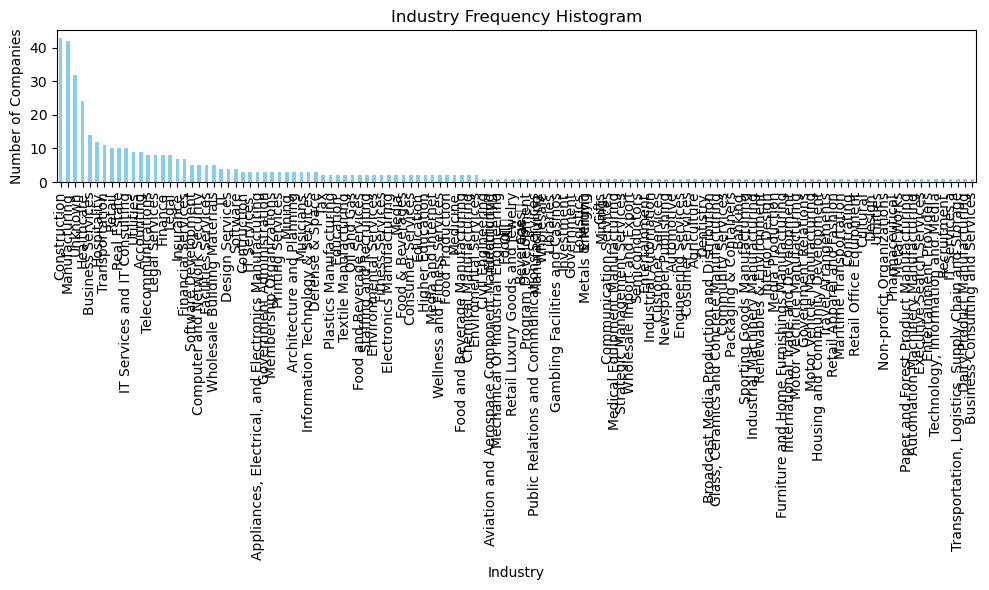

C:\Users\Banan\AppData\Local\Temp\ipykernel_21896\502958770.py:32: UserWarning: Glyph 13 (
) missing from current font.
  plt.tight_layout()
C:\Users\Banan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


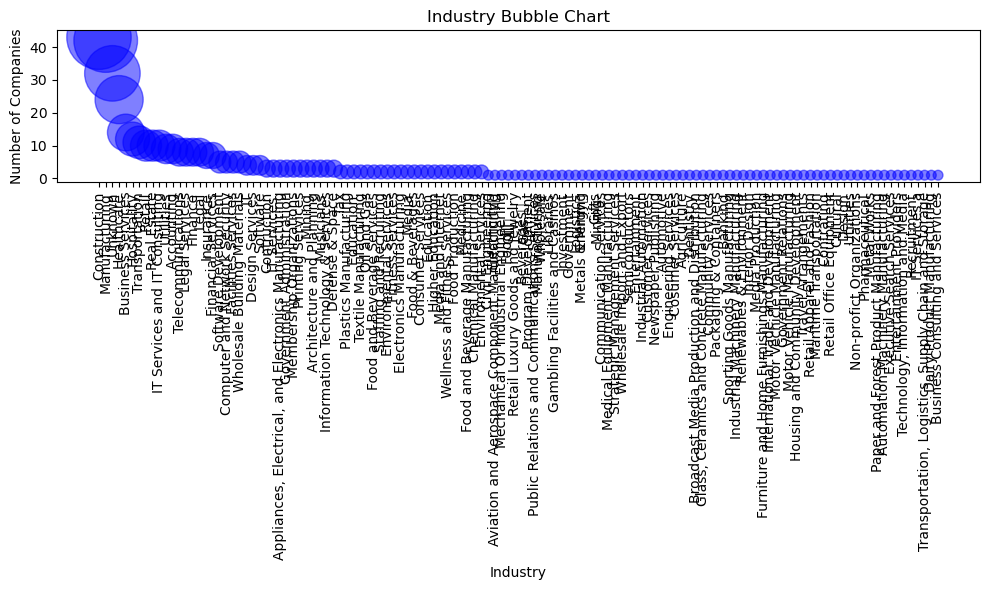

C:\Users\Banan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


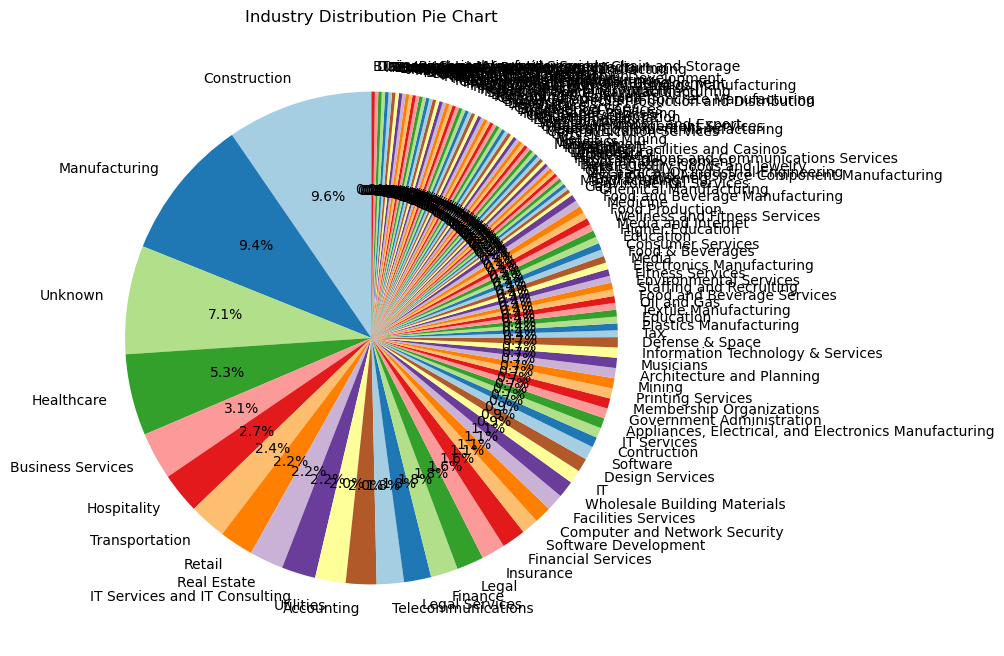

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file from the parent directory
file_path = 'csv/merged_bianlian_dates_remove_qilin_dates.csv'
data = pd.read_csv(file_path)

# Remove rows with missing Industry values
data_clean = data.dropna(subset=['Industry'])

# Group data by industry
industry_counts = data_clean['Industry'].value_counts()

# 1. Histogram
plt.figure(figsize=(10, 6))
industry_counts.plot(kind='bar', color='skyblue')
plt.title('Industry Frequency Histogram')
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Bubble Chart
plt.figure(figsize=(10, 6))
plt.scatter(industry_counts.index, industry_counts.values, 
            s=industry_counts.values * 50, alpha=0.5, color='blue')
plt.title('Industry Bubble Chart')
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Pie Chart
plt.figure(figsize=(8, 8))
industry_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Industry Distribution Pie Chart')
plt.ylabel('')  # Hide the y-label
plt.show()


In [8]:
pd.set_option('display.max_rows', None)

# Get unique industries and their counts
unique_industries = data_clean['Industry'].value_counts()

# Print the unique industries and their count
print("Unique industries and their counts:")
display(pd.DataFrame(unique_industries))

# Print the number of unique industries
print("\nTotal number of unique industries:", unique_industries.count())


Unique industries and their counts:


,Industry
Construction,43
Manufacturing,42
Unknown,32
Healthcare,24
Business Services,14
Hospitality,12
Transportation,11
Retail,10
Real Estate,10
IT Services and IT Consulting,10



Total number of unique industries: 126
